# Import Libraries

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import requests
from fake_useragent import UserAgent
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
import bs4
import time

# Read Dataset

In [2]:
df = pd.read_excel('new_data.xlsx')

In [3]:
# To Create the Simple report quickly
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/37 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Issues

In [4]:
# Go to Overview -> Warnings
# card_present_flag, merchant_id, merchant_suburb, merchant_state, merchant_long_lat have 4326 (35.9%) missing values.
# merchant_code, bpay_biller_code have 11160 (92.7%) missing values.
# There are total 15.9% missing cells in dataset.

# Data Insights

In [5]:
# currency column has only 1 unique value i.e AUD.
# country column has only 1 unique value i.e Australia.
# transaction_id has all unique values.

In [6]:
# each customer has only 1 account.
for i in df['customer_id'].unique():
    x=df.loc[df['customer_id']==i]['account'].nunique()
    if(x!=1):
        print(i,x)

In [7]:
# Fact - gender and age must be unique for each customer. 
# This fact holds true with this dataset. No problem here.
for i in df['customer_id'].unique():
    x=df.loc[df['customer_id']==i]['gender'].nunique()
    y=df.loc[df['customer_id']==i]['age'].nunique()
    if(x!=1 or y!=1):
        print(i)

In [8]:
# Go to Variables -> date -> See Minimum and Maximum
# Minimum date of transaction = 2018-08-01 (August)
# Maximum date of transaction = 2018-10-31 (October)
df['txn_month']=df['date'].apply(lambda x : int(str(x)[5:7]))

df['txn_day']=df['date'].apply(lambda x : int(str(x)[8:10]))

bins= list(range(1,40,7))
labels = ['W1','W2','W3','W4','W5']
df['txn_week'] = pd.cut(df['txn_day'], bins=bins, labels=labels, right=False)

In [9]:
df=df[['customer_id','gender','age','customer_state','txn_month','txn_week','txn_day','amount','status','txn_description', 'movement','balance']]
#df=df.loc[df['status']!='posted']
df=df.sort_values(by=['customer_id','txn_month','txn_week','txn_day']).reset_index(drop=True)
df.head()

,customer_id,gender,age,customer_state,txn_month,txn_week,txn_day,amount,status,txn_description,movement,balance
0,CUS-1005756958,F,53,QLD,8,W1,2,6.48,authorized,POS,debit,463.96
1,CUS-1005756958,F,53,QLD,8,W1,2,39.95,authorized,SALES-POS,debit,424.01
2,CUS-1005756958,F,53,QLD,8,W1,3,22.96,authorized,POS,debit,401.05
3,CUS-1005756958,F,53,QLD,8,W1,3,9.11,authorized,POS,debit,391.94
4,CUS-1005756958,F,53,QLD,8,W1,3,14.65,authorized,SALES-POS,debit,377.29


In [10]:
df.to_excel('prediction_dataset.xlsx',index=False)

## Amount

In [11]:
# average transaction amount 
df['amount'].mean()

187.93358797641724

In [12]:
# average debited transaction amount 
df.loc[df['movement']=='debit']['amount'].mean()

52.57234318996445

In [13]:
# average credited transaction amount 
df.loc[df['movement']=='credit']['amount'].mean()

1898.7280294450718

## Customer Transaction State

In [14]:
# Most of the debit transactions made by customers are from NSW state. 
df.loc[df['movement']=='debit']['customer_state'].value_counts()/df.loc[df['movement']=='debit'].shape[0]

NSW    0.474104
VIC    0.194265
QLD    0.162545
WA     0.100090
SA     0.049821
NT     0.016129
ACT    0.003047
Name: customer_state, dtype: float64

In [15]:
# 22 % of the customers made transactions from VIC state.
# 9 % of the customers made transactions from QLD state. Same for WA state.
for i in df['customer_state'].unique():
    k=df.loc[df['customer_state']==i]['customer_id'].nunique()/df['customer_id'].nunique()
    print(i,k)

QLD 0.09
WA 0.09
NSW 0.52
SA 0.05
VIC 0.22
NT 0.02
ACT 0.01


In [16]:
# NSW had the highest amount contribution in debit transactions.
df.loc[df['movement']=='debit'].groupby(['customer_state']).sum()['amount']/sum(df.loc[df['movement']=='debit']['amount'])

customer_state
ACT    0.006254
NSW    0.516046
NT     0.024386
QLD    0.114336
SA     0.038841
VIC    0.202020
WA     0.098116
Name: amount, dtype: float64

## Movement

In [17]:
# Go to Variables -> movement
# Number of debit records are way more than credit records in 3 months.

In [18]:
# All the customers engaged in debit
df.loc[df['movement']=='debit']['customer_id'].nunique()/df['customer_id'].nunique()

1.0

In [19]:
# Top 10 customers who made highest debit amount transaction in 3 months.
x=df.loc[df['movement']=='debit'].groupby(['customer_id']).sum().reset_index()[['customer_id','amount']]
x=x.sort_values('amount',ascending=False)
x[:10]

,customer_id,amount
7,CUS-1271030853,12865.68
56,CUS-2738291516,12327.28
90,CUS-51506836,12051.77
46,CUS-2487424745,12020.21
84,CUS-4142663097,11964.98
68,CUS-325142416,11336.60
36,CUS-2142601169,10668.76
19,CUS-1617121891,9784.36
55,CUS-2695611575,9553.12
59,CUS-3026014945,9193.29


In [20]:
# All the customers engaged in credit
df.loc[df['movement']=='credit']['customer_id'].nunique()/df['customer_id'].nunique()

1.0

## Transaction description

In [21]:
# Go to Variables -> txn_description
# Highest number of records are of SALES-POS

In [22]:
# A customer receives salary. Hence, movement should only be credit for salary. This is true. No problem here.
df.loc[df['txn_description']=='PAY/SALARY']['movement'].unique()

array(['credit'], dtype=object)

In [23]:
# A customer makes a payment. Hence, movement should only be debit for salary.This is true. No problem here.
df.loc[df['txn_description']=='PAYMENT']['movement'].unique()

array(['debit'], dtype=object)

In [24]:
# Most of the debit transactions made by customers are for SALES-POS. Least for Phone Bank.
df.loc[df['movement']=='debit']['txn_description'].value_counts()/df.loc[df['movement']=='debit'].shape[0]

SALES-POS     0.352509
POS           0.338978
PAYMENT       0.232975
INTER BANK    0.066487
PHONE BANK    0.009050
Name: txn_description, dtype: float64

In [25]:
# Only Salary is involved in credit.
df.loc[df['movement']=='credit']['txn_description'].value_counts()

PAY/SALARY    883
Name: txn_description, dtype: int64

In [26]:
# Payment had the highest amount contribution in debit transactions.
df.loc[df['movement']=='debit'].groupby(['txn_description']).sum()['amount']/sum(df.loc[df['movement']=='debit']['amount'])

txn_description
INTER BANK    0.109648
PAYMENT       0.343943
PHONE BANK    0.018265
POS           0.260541
SALES-POS     0.267604
Name: amount, dtype: float64

In [27]:
# All the customers engage in POS, Payment and Salary transaction in 3 months.
for i in df['txn_description'].unique():
    k=df.loc[df['txn_description']==i]['customer_id'].nunique()/df['customer_id'].nunique()
    print(i,k)

POS 1.0
SALES-POS 0.99
PAYMENT 1.0
PAY/SALARY 1.0
PHONE BANK 0.16
INTER BANK 0.68


## Transaction month

In [28]:
# number of transactions in each month.
# October has the highest entries.
df['txn_month'].value_counts()/df['txn_month'].shape[0]

10    0.339367
9     0.333223
8     0.327410
Name: txn_month, dtype: float64

<AxesSubplot:xlabel='txn_month'>

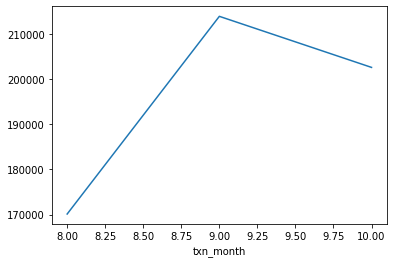

In [29]:
# Trend - total spending from August to October
x=df.loc[df['movement']=='debit'].groupby(['txn_month']).sum()['amount']
x.plot.line()

In [30]:
# All the customers made transaction in each of the 3 months.
for i in df['txn_month'].unique():
    k=df.loc[df['txn_month']==i]['customer_id'].nunique()/df['customer_id'].nunique()
    print(i,k)

8 1.0
9 1.0
10 1.0


## Transaction week

In [31]:
# Which week had most number of transactions in each month?
for i in df['txn_month'].unique():
    print('Month:',i)
    print(df.loc[df['txn_month']==i]['txn_week'].value_counts()/df.loc[df['txn_month']==i].shape[0])
    print('*'*50)

Month: 8
W4    0.239412
W2    0.228760
W1    0.222419
W3    0.199087
W5    0.110322
Name: txn_week, dtype: float64
**************************************************
Month: 9
W1    0.237478
W4    0.236980
W3    0.233491
W2    0.232744
W5    0.059307
Name: txn_week, dtype: float64
**************************************************
Month: 10
W1    0.232200
W3    0.230732
W4    0.228774
W2    0.227061
W5    0.081233
Name: txn_week, dtype: float64
**************************************************


In [32]:
# Which week had most number of transactions in 3 months.
# Week 1 of September (Week 6)
df.groupby(['txn_month','txn_week']).count().reset_index()['customer_id']/df.shape[0]

0     0.072822
1     0.074898
2     0.065183
3     0.078386
4     0.036121
5     0.079133
6     0.077555
7     0.077805
8     0.078967
9     0.019763
10    0.078801
11    0.077057
12    0.078303
13    0.077638
14    0.027568
Name: customer_id, dtype: float64

<AxesSubplot:>

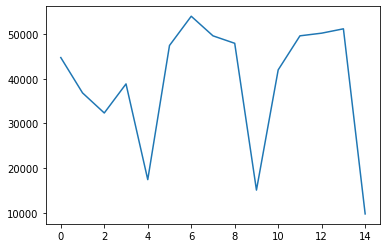

In [33]:
# Trend - total spending in each week from August to October
x=df.loc[df['movement']=='debit'].groupby(['txn_month','txn_week']).sum().reset_index()['amount']
x.plot.line()

In [34]:
# Only 67% of the customers engaged in transaction activity in last week of september.
for i in df['txn_month'].unique():
    print('Month:',i)
    for j in df['txn_week'].unique():
        k=df.loc[(df['txn_month']==i) & (df['txn_week']==j)]['customer_id'].nunique()/df['customer_id'].nunique()
        print(j,k)
    print('*'*50)

Month: 8
W1 1.0
W2 0.99
W3 0.98
W4 0.98
W5 0.92
**************************************************
Month: 9
W1 0.98
W2 0.98
W3 0.98
W4 1.0
W5 0.67
**************************************************
Month: 10
W1 0.98
W2 1.0
W3 1.0
W4 1.0
W5 0.89
**************************************************
